# Transfer Learning


Transfer learning is a machine learning method where a model developed for a task is reused as the starting point for a model on a second task.

It is a popular approach in deep learning where pre-trained models are used as the starting point on computer vision and natural language processing tasks given the vast compute and time resources required to develop neural network models on these problems and from the huge jumps in skill that they provide on related problems.

We'll be using a pretrained model for the Cats vs Dogs dataset.

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# The libraries below are built-into python and are used to work with local storage and directories
import os 

In [ ]:
tf.random.set_seed(42)

### Download & Preprocess Data

First, we'll need to download and unzip the images, for that we'll be using the bang `!` keyword to run terminal commands, we'll use `wget` to download and `unzip` to extract files.

In [ ]:
!!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip 

['--2022-03-19 13:21:59--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip',
 'Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 108.177.98.128, 74.125.195.128, ...',
 'Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.',
 'HTTP request sent, awaiting response... 200 OK',
 'Length: 68606236 (65M) [application/zip]',
 'Saving to: ‘cats_and_dogs_filtered.zip’',
 '',
 '',
 '          cats_and_   0%[                    ]       0  --.-KB/s               ',
 '         cats_and_d  74%[=============>      ]  48.87M   244MB/s               ',
 'cats_and_dogs_filte 100%[===================>]  65.43M   199MB/s    in 0.3s    ',
 '',
 '2022-03-19 13:21:59 (199 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]',
 '']

In [ ]:
!unzip cats_and_dogs_filtered.zip 

Archive:  cats_and_dogs_filtered.zip
   creating: cats_and_dogs_filtered/
  inflating: cats_and_dogs_filtered/vectorize.py  
   creating: cats_and_dogs_filtered/validation/
   creating: cats_and_dogs_filtered/train/
   creating: cats_and_dogs_filtered/validation/dogs/
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2127.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2126.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2125.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2124.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2123.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2122.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2121.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2120.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2119.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2118.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2117.

This is how the dataset directory is laid out:

```
cats_and_dogs_filtered
└───train
│   └───cats
│   │   │   cat.0.jpg
│   │   │   cat.1.jpg
│   │   │   ...
│   └───dogs
│       │   dog.0.jpg
│       │   dog.1.jpg
│       │   ...
└───validation
│   └───cats
│   │   │   cat.2000.jpg
│   │   │   cat.2001.jpg
│   │   │   ...
│   └───dogs
│       │   dog.2000.jpg
│       │   dog.2001.jpg
│       │   ...
```

We'll create a function that takes in the path of either the train or validation folders, loops over the folders and files inside it, and finally return a tuple of the image paths and image labels (i.e. the x's and y's).

In [ ]:
def create_cats_vs_dogs_dataset_from_path(path):

  # Create the arrays that will hold the paths and labels
  image_paths = []
  image_labels = []
  
  # os.listdir returns an array of the files or directories in the specified path 
  for dir in os.listdir(path): # This loops over ['cats', 'dogs']
    for file in os.listdir(f"{path}/{dir}"): # This loops over all the images inside the directoy
      
      # Create the full path of the image
      image_path = f'{path}/{dir}/{file}'
      # Assign the label depending on the directory, 0 for cats and 1 for dogs
      image_label = 0 if dir == 'cats' else 1 

      # Append the image path and label to the arrays we defined earlier
      image_paths.append(image_path)
      image_labels.append(image_label)

  # Convert the arrays to Numpy arrays
  image_paths = np.array(image_paths)
  image_labels = np.array(image_labels)

  # Return the tuple
  return image_paths, image_labels

Now we'll use the function above to create the train and testing dataset by passing the path of the train and validation directories respectively.

In [ ]:
image_paths_train, labels_train = create_cats_vs_dogs_dataset_from_path('/content/cats_and_dogs_filtered/train')
image_paths_test, labels_test = create_cats_vs_dogs_dataset_from_path('/content/cats_and_dogs_filtered/validation')

image_paths_train.shape, labels_train.shape, image_paths_test.shape, labels_test.shape

((2000,), (2000,), (1000,), (1000,))

Let's take a look at a few samples from the data we created so far

In [ ]:
# We're splicing the middle of the numpy array to get both cats and dogs.
print("Training Image Paths:\n", image_paths_train[995:1005])
print("Training Image Labels:\n", labels_train[995:1005])

Training Image Paths:
 ['/content/cats_and_dogs_filtered/train/cats/cat.748.jpg'
 '/content/cats_and_dogs_filtered/train/cats/cat.372.jpg'
 '/content/cats_and_dogs_filtered/train/cats/cat.23.jpg'
 '/content/cats_and_dogs_filtered/train/cats/cat.581.jpg'
 '/content/cats_and_dogs_filtered/train/cats/cat.95.jpg'
 '/content/cats_and_dogs_filtered/train/dogs/dog.38.jpg'
 '/content/cats_and_dogs_filtered/train/dogs/dog.454.jpg'
 '/content/cats_and_dogs_filtered/train/dogs/dog.365.jpg'
 '/content/cats_and_dogs_filtered/train/dogs/dog.287.jpg'
 '/content/cats_and_dogs_filtered/train/dogs/dog.280.jpg']
Training Image Labels:
 [0 0 0 0 0 1 1 1 1 1]


### Create TensorFlow Data Pipeline

Now we're going to define the functions that will be used to create the pipeline, we'll first start with a function that takes an image path and label pair and returns the image tensor and the same label 

In [ ]:
def get_image_tensor_from_path(image_path, label):

    image = tf.io.read_file(image_path) # Read and output the entire contents of the input file.
    image = tf.image.decode_jpeg(image) # Convert the content of the file to a 3D Tensor (height, width, color_channels).
    image = tf.image.convert_image_dtype(image, tf.float32) # Convert the tensor values (i.e. pixel brightness) to floats between 0 and 1
    image = tf.image.resize(image, (224,224)) # Resize the image to a fixed square size of 224 by 224

    return image, label

Next we'll define the image augmentation function that will apply random transformations to the image

In [ ]:
# This is the same function that was defined in the CIFAR10 example

def augment_image(image, label):

  image = tf.image.random_flip_left_right(image) # Randomly flip an image horizontally
  image = tf.image.random_flip_up_down(image) # Randomly flips an image vertically
  image = tf.image.random_brightness(image, max_delta=32.0/255.0) # Adjust the brightness of images by a random factor
  image = tf.image.random_saturation(image, lower=0.5, upper=1.5) # Adjust the saturation of RGB images by a random factor
    
  # Make sure the image's pixel values are still between 0 and 1
  image = tf.clip_by_value(image, 0.0, 1.0)
    
  return image, label

And finally, the dataset creator function that will put everything together

In [ ]:
def cat_v_dog_dataset_creator(x, y, batch_size = 32, training=False):

  data = tf.data.Dataset.from_tensor_slices((x,y))
  data = data.shuffle(2000) # Shuffle the data, `2000` represnts the buffer size, read the documentation for more details

  # Convert image paths to image tensors using get_image_tensor_from_path
  data = data.map(get_image_tensor_from_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

  if training: # If training == True then apply train preprocess on dataset, this makes sure that the validation dataset isn't augmented
    data = data.map(augment_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) # Applying the augment_image function on dataset

  data = data.batch(batch_size) # Create mini-batches for the specified size

  # This allows later elements to be prepared while the current element is being processed.
  data = data.prefetch(tf.data.experimental.AUTOTUNE)

  return data

In [ ]:
train_dataset = cat_v_dog_dataset_creator(image_paths_train, labels_train, training=True)
test_dataset = cat_v_dog_dataset_creator(image_paths_test, labels_test)

In the cell below, we'll take a batch from the `train_dataset` and show 25 samples from them to see the effect of the transformations.

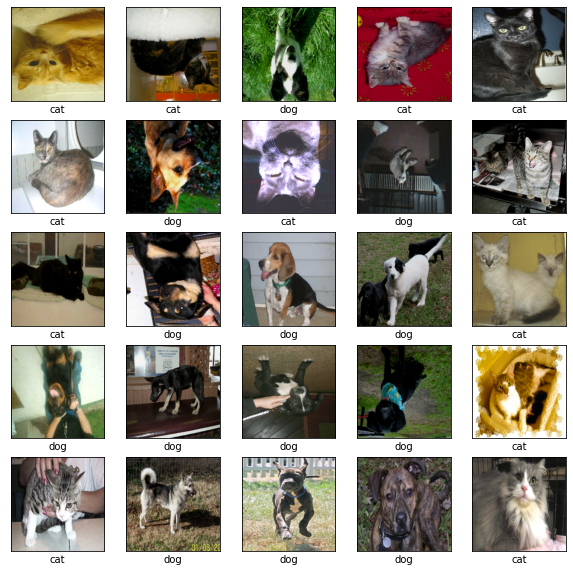

In [ ]:
class_names = ['cat', 'dog']

for x, y in train_dataset.take(1):
  
  plt.figure(figsize=(10,10))
  
  for i in range(25):
    plt.subplot(5,5,i+1) # Create a subplot on a 5x5 grid for index i

    plt.xticks([]) # Remove the ticks of the number line from the x axis 
    plt.yticks([]) # Remove the ticks of the number line from the y axis 

    plt.imshow(x[i]) # Plot the image, no need to use the cmap parameter since this image is in RGB

    plt.xlabel(class_names[y[i]]) # Add the class name below the image 

## Loading Pretrained Model

The usual workflow for transfer learning is the following: 

1. Freeze all layers in the base model by setting trainable = False.
2. Create a new model on top of the output of one (or several) layers from the base model.
3. Train your new model on your new dataset.


Note that an alternative, more lightweight workflow could also be:

1. Instantiate a base model and load pre-trained weights into it.
2. Run your new dataset through it and record the output of one (or several) layers from the base model. This is called feature extraction.
3. Use that output as input data for a new, smaller model.

An issue with that workflow, though, is that it doesn't allow you to dynamically modify the input data of your new model during training, which is required when doing data augmentation, for instance. Transfer learning is typically used for tasks when your new dataset has too little data to train a full-scale model from scratch, and in such scenarios data augmentation is very important. So in what follows, we will focus on the first workflow.

In TensorFlow, we'll start by loading the pretrained model from `tf.keras.applications` API, a full list of available pretrained models can be found here: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [ ]:
pretrained_model = tf.keras.applications.DenseNet121(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False # Do not include the ImageNet classifier at the top, we'll only be using the convolutional layers
)  

pretrained_model.summary()

29097984/29084464 [==============================] - 0s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                       

Notice how there are ~7 millions trainable parameters, since we don't intend to tuning the existing weights, we'll set the `trainable` attribute of the pretrained model to `False` 

In [ ]:
pretrained_model.trainable = False
pretrained_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

## Build & Train Model
In order to create a new model that leverages the pretrained model, we'll be using TensorFlow's Functional API instead of Sequential, more information on the Functional API can be found here: https://www.tensorflow.org/guide/keras/functional

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))

# We make sure that the pretrained_model is running in inference mode here by passing `training=False`.
x = pretrained_model(inputs, training=False)

# Flatten the feature vectors to a single vector
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Create the feed-forward `Dense` part of the network
x = tf.keras.layers.Dense(128,activation=tf.nn.relu)(x)
x = tf.keras.layers.Dropout(0.1)(x)

# An output layer with a single unit (binary classification)
outputs = tf.keras.layers.Dense(1,activation=tf.nn.sigmoid)(x)

# Finally create the model by piecing together the layers between the input and output layers
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               131200    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
save_best_model = tf.keras.callbacks.ModelCheckpoint('/content/Models/1', save_best_only=True)

In [ ]:
model.fit(train_dataset, epochs=3,validation_data=test_dataset, callbacks=[save_best_model])

Epoch 1/3
63/63 [==============================] - ETA: 0s - loss: 0.1049 - accuracy: 0.9555

KeyboardInterrupt: ignored

In comparision, our original model for a validation accuracy of 0.6420 after 20 epoches, so not only did transfer learning increase our model's accuracy, it did so in less training time.

## Plot Training History

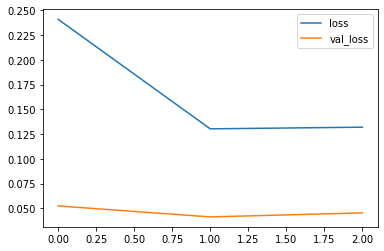

In [ ]:
pd.DataFrame(model.history.history)[['loss', 'val_loss']].plot.line()

In [ ]:
!echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0   159k      0 --:--:-- --:--:-- --:--:--  159k
OK


In [ ]:
!apt-get update
!apt-get install tensorflow-model-server

In [ ]:
%%bash --bg 
tensorflow_model_server --port=8500 --rest_api_port=8501 \
                        --model_name=CatVsDog \
                        --model_base_path=/content/Models >server.log 2>&1

Starting job # 0 in a separate thread.


In [ ]:
# Run the following command to show the server logs
!tail /content/server.log

2022-03-19 13:16:27.520316: E tensorflow_serving/sources/storage_path/file_system_storage_path_source.cc:365] FileSystemStoragePathSource encountered a filesystem access error: Could not find base path /content/Model for servable CatVsDog with error NOT_FOUND: /content/Model not found
2022-03-19 13:16:28.520362: E tensorflow_serving/sources/storage_path/file_system_storage_path_source.cc:365] FileSystemStoragePathSource encountered a filesystem access error: Could not find base path /content/Model for servable CatVsDog with error NOT_FOUND: /content/Model not found


In [ ]:
# import requests to make a prediction
import requests
# import json to convert the response to a python dictionary
import json

In [ ]:
# create read_image function to read the image from the path
def read_image(image_path, ):

    image = tf.io.read_file(image_path) # Read and output the entire contents of the input file.
    image = tf.image.decode_jpeg(image) # Convert the content of the file to a 3D Tensor (height, width, color_channels).
    image = tf.image.convert_image_dtype(image, tf.float32) # Convert the tensor values (i.e. pixel brightness) to floats between 0 and 1
    image = tf.image.resize(image, (224,224)) # Resize the image to a fixed square size of 224 by 224

    return image

In [ ]:
# create predict function to make a prediction
def predictions(path):
    # read the image
    image = read_image(path)
    # add a batch dimension and convert the image to a numpy array
    image = np.expand_dims(image,0)
    # create a json object with the image
    data = json.dumps({"signature_name": "serving_default", "instances":image.tolist()})
    # create a headers object with the content type
    headers = {"content-type": "application/json"}
    # make a post request to the model server with the data and headers
    json_response = requests.post('http://localhost:8501/v1/models/CatVsDog:predict', data=data, headers=headers)
    # convert the json response to a python dictionary
    pred = json.loads(json_response.text)
    # print the prediction
    print(pred)
    # return the prediction
    return pred['predictions'][0]

In [ ]:
# predict the image
predictions('/content/cats_and_dogs_filtered/validation/cats/cat.2009.jpg')

{'predictions': [[0.0264090598]]}


[0.0264090598]

In [ ]:
def read_image(image_path):

    image = tf.io.read_file(image_path) # Read and output the entire contents of the input file.
    image = tf.image.decode_jpeg(image) # Convert the content of the file to a 3D Tensor (height, width, color_channels).
    image = tf.image.convert_image_dtype(image, tf.float32) # Convert the tensor values (i.e. pixel brightness) to floats between 0 and 1
    image = tf.image.resize(image, (224,224)) # Resize the image to a fixed square size of 224 by 224

    return image

In [ ]:
saved_model = tf.keras.models.load_model('/content/Model')

In [ ]:
import time
def prediction(data, model):
  img = read_image(data)
  img = tf.expand_dims(img, 0)
  start_time = time.time()
  pred = model.predict(img)
  end_time = time.time()
  print(end_time-start_time)
  return pred[0][0]

In [ ]:
prediction('/content/cats_and_dogs_filtered/validation/cats/cat.2004.jpg', saved_model)

3.3596513271331787


0.00026885554

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model('/content/Model')
tflite_model = converter.convert()

In [ ]:
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
interpretor = tf.lite.Interpreter('/content/model.tflite')
interpretor.allocate_tensors()

In [ ]:
input_details = interpretor.get_input_details()
output_details = interpretor.get_output_details()

In [ ]:
output_details

[{'dtype': numpy.float32,
  'index': 626,
  'name': 'StatefulPartitionedCall:0',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([1, 1], dtype=int32),
  'shape_signature': array([-1,  1], dtype=int32),
  'sparsity_parameters': {}}]

In [ ]:
import time
def tflite_pred(data, model, input_details, output_details):
  img = read_image(data)
  img = tf.expand_dims(img, 0)

  start_time = time.time()
  model.set_tensor(input_details[0]['index'], img)

  model.invoke()
  end_time = time.time()
  pred = model.get_tensor(output_details[0]['index'])
  print(end_time-start_time)
  return pred[0][0]

In [ ]:
image_path = '/content/cats_and_dogs_filtered/validation/dogs/dog.2001.jpg'
tflite_pred(image_path, interpretor, input_details, output_details)

0.20960545539855957


0.9999913

# TensorFlow Hub
**TensorFlow Hub** is a repository of trained machine learning models ready for fine-tuning and deployable anywhere. Reuse trained models like BERT and Faster R-CNN with just a few lines of code.**

The TensorFlow Hub project makes it easy to reuse pretrained model components in your own models. These model components are called modules. Simply browse the [TF Hub repository](https://tfhub.dev/), find the one you need, and copy the code example into your project, and the module will be automatically downloaded, along with its pretrained
weights, and included in your model. Easy!

For example, let’s use the Resnet V2  module, version 5, in
our classification model :

In [ ]:
#import the tensorlfow hub 
import tensorflow_hub as hub

# load the ResNet v2  module 

The usual workflow for transfer learning is the following: 

1. Freeze all layers in the base model by setting trainable = False.
2. Create a new model on top of the output of one (or several) layers from the base model.
3. Train your new model on your new dataset.


Note that an alternative, more lightweight workflow could also be:

1. Instantiate a base model and load pre-trained weights into it.
2. Run your new dataset through it and record the output of one (or several) layers from the base model. This is called feature extraction.
3. Use that output as input data for a new, smaller model.

An issue with that workflow, though, is that it doesn't allow you to dynamically modify the input data of your new model during training, which is required when doing data augmentation, for instance. Transfer learning is typically used for tasks when your new dataset has too little data to train a full-scale model from scratch, and in such scenarios data augmentation is very important. So in what follows, we will focus on the first workflow.


In [ ]:
#load the trained ResNet V2 feature vector module
ResNetV2= hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/5",trainable=False,)


The hub.KerasLayer layer downloads the module from the given URL. This particular module is an image feature vector: it takes image as input and encodes to single vector of features(in this case, a 2048-dimensional vector). 
 We can then add two simple Dense layers to create a good image classification model. By default, a hub.KerasLayer is not trainable, but you can set `trainable=True` when creating it to change that so that you can fine-tune it for your task.

In [ ]:
model = tf.keras.Sequential([
tf.keras.layers.Input((224,224,3)),                         
 ResNetV2,
 tf.keras.layers.Dense(128, activation="relu"),
 tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam",
 metrics=["accuracy"])


In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 2048)              23561152  
                                                                 
 dense_12 (Dense)            (None, 128)               262272    
                                                                 
 dense_13 (Dense)            (None, 1)                 129       
                                                                 
Total params: 23,823,553
Trainable params: 262,401
Non-trainable params: 23,561,152
_________________________________________________________________


## train the model 

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
model.fit(train_dataset, epochs=5,validation_data=test_dataset)

Epoch 1/5
63/63 [==============================] - 31s 308ms/step - loss: 0.2159 - accuracy: 0.9115 - val_loss: 0.0601 - val_accuracy: 0.9740
Epoch 2/5
63/63 [==============================] - 23s 275ms/step - loss: 0.0720 - accuracy: 0.9650 - val_loss: 0.0424 - val_accuracy: 0.9860
Epoch 3/5
63/63 [==============================] - 23s 274ms/step - loss: 0.0375 - accuracy: 0.9890 - val_loss: 0.0436 - val_accuracy: 0.9860
Epoch 4/5
63/63 [==============================] - 23s 275ms/step - loss: 0.0209 - accuracy: 0.9945 - val_loss: 0.0430 - val_accuracy: 0.9830
Epoch 5/5
63/63 [==============================] - 23s 274ms/step - loss: 0.0101 - accuracy: 0.9990 - val_loss: 0.0485 - val_accuracy: 0.9860


In comparision, our original model for a validation accuracy of 0.6420 after 20 epoches, so not only did transfer learning increase our model's accuracy, it did so in less training time.

## Plot Training History

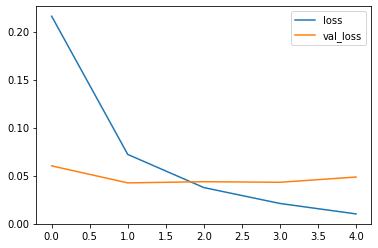

In [ ]:
pd.DataFrame(model.history.history)[['loss', 'val_loss']].plot.line()